# Projet Recherche Opérationelle - Branch And Bound

## Introduction

Lors de ce projet nous nous sommes penchés sur l'implémentation de l'algorithme de branch-and-bound pour un problème d'ordonnancement étudié en TD (présentation détaillée problème ci dessous). Outre la mise en pratique des connaissances aquises au cours de ce semestre, ce projet nous aura permis une compréhension plus fine de cet algorithme, en travaillant nottament sur chaque composante de l'algorithme : 
* sa règle de branchement 
* sa méthode d'exploration 
* le calcul de ses bornes (primales et duales)


__Le problème considéré :__

Un atelier de production doit usiner un ensemble $J=\{1,\dots,n\}$ de pièces. Pour cela, l'atelier possède une machine unique. Chaque pièce $j \in J$ nécessitera $p_j$ unités de temps pour être usinée. Nous supposons que l'on se trouve à la date t=0 et chaque pièce $j \in J$ doit être prête à la date $d_j$. Si cette date n'est pas respectée, l'usine devra payer une pénalité $w_j$ par unité de temps de retard. Il s'agit donc d'un __problème de minimisation__ dans lequel nous devons déterminer l'ordre de passage des pièces sur la machine qui peremttra de minimiser les pénalités de retard.

__Le plan du projet :__

* __Structures de données__

Choix des différentes structures utiles pour l'algorithme et pour définir les instances du problème. 

* __Déclaration externe de méthodes utiles pour branch and bound__ 

Implémentation de diverses méthodes utiles lors de l'implémentation de l'algorithme de branch and bound. 

* __Travail sur les composantes de branch and bound__ 

Nous implémentons différentes méthodes de calcul de bornes primales et duales ainsi que différentes méthodes d'exploration de l'arbre de branchement. Nous étudierons l'effet de ces différentes méthodes sur les performances de l'algorithme.

* __Algorithme de branch and bound__ 

Nous implémentons l'algorithme de branch and bound. 

* __Evaluation des performances__ 

Nous étudions la performance de l'algorithme en modifiant ses composantes (méthodes de calcul de bornes duales et primales, méthode d'exploration).

* __Visualisation de l'arbre de branchement__




## Importation des modules

Nous importons tout d'abord tous les modules nécessaires dans ce projet. Nous utilisons les modules classiques __numpy__ et __matplotlib (pyplot)__. Nous utilisons égalements les modules __networkx__ et un module particulier de pydot (cellule pour installation ci dessous) lors de la visualisation de parcours de l'arbre de branchement.

In [1]:
conda install pydot

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import math
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from matplotlib import pyplot as plt
import copy

## Structure de données

*Nous définissons un certain nombre de structures de données, liées au problème ou à l'algorithme de Branch and Bound.*

### Les instances du problème

Le problème possède 3 données clefs : 
* le nombre d'unités de temps nécessaire à l'usinage de chaque pièce
* la date d'usinage a laquelle chque pièce doit être usinée
* la pénalité de retard associée à chaque pièce

Nous faisons le choix d'utiliser des listes pour stocker ces 3 instances du problème. Un problème donné sera donc caractérisé par 3 listes : 
* une liste __p__
* une liste __d__
* une liste __w__

### Les noeuds 

Chaque noeud de l'arbre de branchement sera un objet. Chaque objet Noeud créé possède :
* Un indexe : __idx__
* Un noeud parent : __parent__
* Une liste de noeuds enfants : __children__
* Une borne duale associée (lower bound ici, puisqu'il s'agit d'un problème de minimisation) : __lb__
* Une liste de noeuds visités : __visited__.
* Une méthode d'affichage.

Dans cette première partie, les index de noeuds seront des entiers, leur stockage sera rapide. Dans la partie __affichage__ les index seront des chaines de caractères plus ou moins longues, leur stockage sera légèrement plus long.

__Exemple__

![Arbre de branchement](EX2.png)

En considérant que les noeud en vert on déjà été visités et que les noeuds rouges ne l'ont pas été, le noeud 1 représenté ci dessus possèderait (selon la structure choisie) les éléments suivants : 
* __idx__=1
* __parent__=0
* __children__=[ 4 , 5 ]
* __visited__=[ 0 ]

In [3]:
class Node:
    
    def __init__(self,idx, parent, children, lb, visited):
        self.idx = idx
        self.parent = parent
        self.children = children
        self.lb = lb
        self.visited = visited
        
    def __str__(self):
        return ("Parent : " +str(self.parent)+
                "\n Children : "+str(self.children) + 
                "\n lb : "+str(self.lb)+ 
                "\n visited : "+str(self.visited))

## Déclaration externe de fonctions utiles pour branch and bound

### Fonctions abroresence et computeCost

*Nous implémentons à présent un certain nombre de fonctions que nous utiliserons lors de l'implémentation de l'algorithme de branch and bound.*

La première fonction est une fonction arborescence. Elle nous permet de donner une branche complète d'arbre de branchement en partant d'une feuille. Dans l'__exemple__ ci-dessus, la fonction : __arborescence(4,Tree)__ renverrait : [4,1,0]. 

In [4]:
def arborescence(node,Tree):
    branch = []
    while node.parent != None:
        branch.append(node.idx)
        node = node.parent
    branch.append(node.idx)
    
    return branch

Afin de déterminer facilement le cout d'une solution donnée, nous implémentons une méthode générale computeCost. A partir des données du problème (p,d,w) et d'un ordre de taches à effectuer, la fonction renvoie le cout de la solution.

In [5]:
def computeCost(p,d,w,order):
    t=0
    cost=0
    for idx in order:
        t += p[idx]
        cost += max(0,(t-d[idx])*w[idx])
    return cost

Afin de tester la dernière méthode nous utilisons le problème vu en TD (*exercice 7, TD branch and bound*) dont les instances sont rappelées ci-dessous : 

* unités de temps pour que les pièces soient usinées : p=[12,8,15,9]
* date auxquelles les pièces doivent être prêtes : d=[16,26,25,27]
* pénalités de retard : w=[4,5,3,5]

In [6]:
p = [12,8,15,9]
d = [16,26,25,27]
w = [4,5,3,5]

La solution que nous testons (ordre d'usinage : [0,1,3,2]) est la solution optimale, obtenue lors du TD. Son coût vaut 67. On vérifie donc que la fonction computeCost nous donne bien 67 avec cet ordre d'usinage.

In [7]:
computeCost(p,d,w,[0,1,3,2])

67

## Travail sur les composantes de Branch and Bound

### Calculs de bornes primales

L'idée de ce projet est de tester différentes composantes de l'algorithme de Branch and Bound, afin de voir leur impact sur les performances de l'algorithme. 

Nous nous concentrons tout d'abord sur le calcul des bornes primales. Le calcul de borne primale s'effectue au début de l'algorithme. Plus le calcul est fin, i.e plus la borne primale obtenue possède une valeur faible, plus l'algorithme ira vite. L'idée est donc d'essayer de trouver la méthode la plus interessante.


Nous avons fait le choix de coder différentes fonctions :
* __getPrimal_0__ : nous calculons une solution en usinant les pièces selon l'ordre croissant des dates d'usinage au plus tard.
* __getPrimal_1__ : nous calculons une solution en usinant les pièces selon l'ordre croissant des (dates d'usinage au plus tard-le temps d'usinage)$*$pénalité

Comme les premières pièces engendrent le moins de retard, nous nous sommes dit qu'il est possible d'obtenir une meilleure borne primale en réflechissant à la position des derniers éléments. Cela nous a amené à la fonction : 
* __getPrimal_2__ : nous calculons une solution en mettant à la dernière position disponible l'élément non traité donnant lieu à la plus petite pénalité de retard.

In [8]:
def getPrimal_0(p,d,w):
    sortedTasks=np.argsort(d)
    cost=computeCost(p,d,w,sortedTasks)
    return(cost,sortedTasks)


def getPrimal_1(p,d,w):
    sortedTasks=(np.argsort((np.array(d)-np.array(p))*np.array(w)))[::-1]
    cost=computeCost(p,d,w,sortedTasks)
    return(cost,sortedTasks)


def getPrimal_2(p,d,w):
    tasksLeft=[int(i) for i in range(len(p))]
    order=[]
    while len(tasksLeft)!= 0:
        time=np.sum(np.array(p)[tasksLeft])
        penalities=(time-np.array(d)[tasksLeft])*np.array(w)[tasksLeft]
        sortedTasks=np.argsort(penalities)
        order.append(tasksLeft[sortedTasks[0]])
        tasksLeft.pop(sortedTasks[0])
    order.reverse()
    cost = computeCost(p,d,w,order)
    return(cost,order)

Nous comparons à présent les résultats de ces méthodes en utilisant les instances p,d,w initialisée ci dessus (*EX7 TD branch and bound*). __Rappel__: plus une fonction de calcul de borne duale est performante, plus la valeur de la borne duale trouvée est petite.

In [9]:
print("Temps production : ", p)
print("Date limite :      ", d)
print("Pénalités :        ", w)
print("0 : ",getPrimal_0(p,d,w))
print("1 : ",getPrimal_1(p,d,w))
print("2 : ",getPrimal_2(p,d,w))

Temps production :  [12, 8, 15, 9]
Date limite :       [16, 26, 25, 27]
Pénalités :         [4, 5, 3, 5]
0 :  (136, array([0, 2, 1, 3]))
1 :  (133, array([3, 1, 2, 0]))
2 :  (67, [0, 1, 3, 2])


__Conclusion :__ la méthode getPrimal_2 est bien plus performante que les méthodes 0 et 1.

### Calcul des bornes duales [A REDIGER]

In [10]:
def getDual_0(p,d,w,visited):
    dual=0
    time=0
    notVisited=list(range(len(p)))
    for i in visited:
        retard=((p[i]+time)-d[i])
        dual+=retard*w[i]*(retard>0)
        time+=p[i]
        notVisited.remove(i)
        
    for j in notVisited:
        retard=(p[j]+time)-d[j]
        dual+=retard*w[j]*(retard>0)
    return dual

def getDual_1(p,d,w,visited):
    dual=0
    time=0
    notVisited=list(range(len(p)))
    for i in visited:
        retard=((p[i]+time)-d[i])
        dual+=retard*w[i]*(retard>0)
        time+=p[i]
        notVisited.remove(i)
        
    return dual

def getDual_2(p,d,w,visited):
    dual=0
    time=np.sum(p)

    for i in visited:
        retard=(time-d[i])
        dual+=retard*w[i]*(retard>0)
        time-=p[i]
        
    return dual

In [11]:
print("Si on a fixé l'ordre de k pièces on calcule les pénalités de retard de ces k pièces et on ajoute les pénalités des autres pièces en supposant qu'elles sont en (k+1)ème position : \n",
      getDual_0(p,d,w,[2,3]))
print("Si on a fixé l'ordre de k pièces on calcule les pénalités de retard de ces k pièces : \n",
      getDual_1(p,d,w,[2,3]))

Si on a fixé l'ordre de k pièces on calcule les pénalités de retard de ces k pièces et on ajoute les pénalités des autres pièces en supposant qu'elles sont en (k+1)ème position : 
 110
Si on a fixé l'ordre de k pièces on calcule les pénalités de retard de ces k pièces : 
 0


### Méthodes d'exploration [A REDIGER]

In [12]:
def exploration_0(Queue,Tree,UB):
    return(Queue[0])

def exploration_1(Queue,Tree,UB):
    return(Queue[-1])

def exploration_2(Queue,Tree,UB):
    bestNode = None
    bestLB = -math.inf
    for i in range(len(Queue)):
        if Tree[Queue[i]].lb > bestLB and Tree[Queue[i]].lb < UB:
            bestLB = Tree[Queue[i]].lb
            bestNode = i
    return(Queue[i])

## Branch and Bound [A REDIGER + A COMPLETER]

In [13]:
###################
#  CODE GOES HERE #
##################

## Performances de l'algorithme de Branch and Bound [A REDIGER + A COMPLETER]

In [14]:
#################################
#         CODE GOES HERE        #
# FAIRE JOUJOU AVEC MATPLOTLIB  #
#################################

## Visualisation de l'arbre de branchement.

L'idée est ici d'implémenter une fonction de visualisation de l'arbre de branchement. 

### Redéfinition de quelques éléments de structure

Comme évoqué aupravant, nous changeons les index des noeuds. Nous sommes conscients que stocker des entiers est moins couteux en temps de calcul que stocker des grandes chaines de caractères et c'est pour cette raison que nous avons fait une nouvelle version de la fonction branch and bound ci dessous. 

Afin de mieux comprendre notre facon d'indexer les noeuds, nous présentons un exemple succinct. 

![Arbre de branchement](EX1.png)

* Le noeud racine sera __P__
* Le noeud __P(1)__ signifie que la solution liée à ce noeud place l'usinage de la pièce 1 en dernier.
* Le noeud __P(2,1)__ signifie que la solution liée à ce noeud place l'usinage de la pièce 1 en dernier, puis celui de la pièce 2 en avant dernier.

Pour des exmples de taille plus conséquente (+ de taches), par exemple 5, certains des noeuds seront instanciés par __P(*4 chiffres séparés par des virgules*)__.

### Branch and bound redéfini

Nous utilisons ces nouvelles indexations pour mettre à jour la fonction branch and bound. 

Notons aussi que nous ajoutons quelques élements de code permettant de trouver la branche de l'arbre qui aura donné lieu à la meilleure solution. Pour cela, nous localisons le meilleur noeud, i.e le noeud qui :
* est tel que la borne duale du noeud est inférieure ou égale à la borne primale du problème                **(1)**
* est tel que la borne duale du noeud est plus grande que n'importe quel borne duale des noeuds vérifiant (1).

Nous remontons ensuite (en utilisant les parents) afin d'obtenir la branche de l'arbre donnant lieu à la meilleure solution. Cela nous sera utile lors de la visualisation de l'arbre de branchement.

Les éléments retournés par la fonction sont également ajustés. Nous ajoutons le retour de : 
* __branch__ : la branche donnant lieu à la solution optimale du problème
* __Tree__: l'arbre correspondant au problème

In [22]:
def branch_and_bound(p,d,w,byLast,getPrimal,getDual,exploration):
    
    Tasks = list(range(len(p)))
    Tree = [] # list of all nodes created (a list of Node objects)
    Queue = [] # list of nodes to process (a list of integers with the index of nodes to process in the Tree)
    UB = 10000000 # set the upper bound to a sufficiently large number
    LB = 0 # set the lower bound to a sufficiently small number 
    
    UB,currentOrder = getPrimal(p,d,w)

    bestNode = Node("",-1, [], 0 ,[])
    
    root = Node("P",None, [], 0, []) # at the root node no variables are fixed 
    Tree.append(root) # start the tree with the root node
    Queue.append(0) # start the list of nodes to process with the root node
    
    #continue processing nodes until the queue is empty
    
    nbIterations = 0
    
    while Queue!=[]:
        
        # process the first node in the queue

        currentIndex = exploration(Queue,None,None)
        currentNode = Tree[currentIndex]
        nbIterations +=1
        
        if currentNode.lb < UB:
            
            if len(currentNode.visited) == len(p):
                order = currentNode.visited.copy()
                if byLast:
                    order.reverse()
                solutionCost = computeCost(p,d,w,order)
                if solutionCost <= UB:
                    UB = solutionCost
                    currentOrder=order
                    bestNode = currentNode
            else:
                for nextTask in (set(Tasks)-set(currentNode.visited)):
                    nextVisited = currentNode.visited.copy()
                    nextVisited.append(nextTask)
                    nextLb = getDual(p,d,w, nextVisited)

                    newNode = Node("",currentNode, [], nextLb,nextVisited)
                    
                    if currentNode.visited!=[]:
                        newNode.idx="P("
                        for i in range(len(nextVisited)-1):
                            newNode.idx+=str(nextVisited[i])+","
                        newNode.idx+=str(nextVisited[len(nextVisited)-1])+")"
                    else:
                        newNode.idx="P("+str(nextTask)+")"
                        
                    Tree.append(newNode)
                    Queue.append(len(Tree)-1)
                    currentNode.children.append(newNode)
            
        # When the processing of the node is completed remove the node from the queue     
        Queue.remove(currentIndex)

    # return the  solution
    
    if 2*(UB-bestNode.lb)<=0.0001:
        branch = arborescence(bestNode,Tree)
    else:
        bestLB = -math.inf
        for node in Tree:
            if node.lb > bestLB and node.lb <=UB:
                bestLB = node.lb
                bestNode=node
        branch = arborescence(bestNode,Tree)

    return UB, currentOrder, nbIterations, branch, Tree

### Fonction d'affichage de l'arbre

Nous implémentons à présent une fonction d'affichage de l'arbre. Cette méthode utilise différents élements de packages spécifiques (importés au préalable, et non utilisés jusqu'alors). Nous utilisons :
* __networkx__ afin de crééer une structure d'arbre facile d'utilisation et facile à représenter.
* __pydot__ qui permettra de visualiser simplement l'abre de branchement.

La méthode consiste principalement à reconstitué l'arbre de branchement à partir de la liste de Noeud __Tree__. De l'afficher de manière adequat, et de mettre en évidence la branche donnant lieu à la solution optimale.

In [23]:
def displayTree(Tree,currentOrder,branch,byLast):
    
    index=['P']
    parent=['P']
    for node in Tree:
        if(node.idx!="P"):
            index.append(node.idx)
            parent.append((node.parent).idx)
    graphe=dict(zip(index,parent))
    
    graph=nx.Graph()
    graph.add_nodes_from(index)
    for idx in graphe.keys():
        graph.add_edge(idx,graphe[idx])
        
    if(byLast==True):
        branch.reverse()

    bestPath= set(zip(branch[:-1], branch[1:]))
    edge_colors=dict()
    for edge in graph.edges():
        if edge in bestPath:
            edge_colors[edge]='red'
        else:
            edge_colors[edge]='lightblue'
            
    node_colors=dict()
    for node in graph.nodes():
        if node in branch:
            node_colors[node]='red'
        else:
            node_colors[node]="lightblue"
    
    plt.figure(figsize=(12,8))
    pos = graphviz_layout(graph, prog="dot")
    nx.draw(graph, pos,with_labels=True,node_size=1200,node_color=node_colors.values(),edge_color=edge_colors.values())
    plt.show()

### Test de la fonction d'affichage

Nous effectuons le test de notre fonction d'affichage. Pour cela, nous prenons différents problèmes. Dans un premier temps, nous utiliserons l'exemple de TD (*EX7 TD Branch and bound*). Nous comparons ensuite l'abre de branchement affiché à celui obtenu lors de la résolution du branch and bound en TD.

In [24]:
#Textbook Example
pj = [12,8,15,9]
dj = [16,26,25,27]
wj = [4,5,3,5]

/Users/Nathan/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/Nathan/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


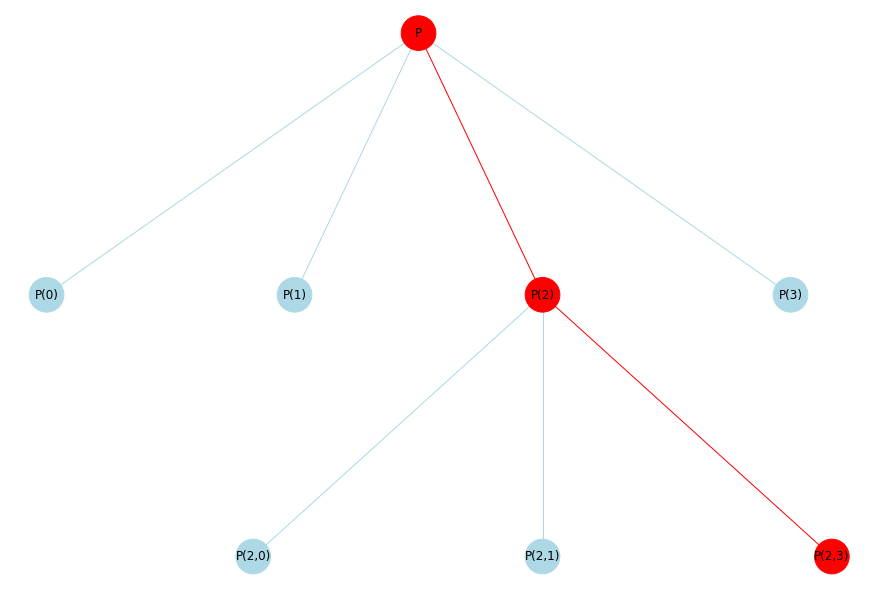

In [25]:
solution,order,nbIterations,branch,Tree=branch_and_bound2(pj,dj,wj, True, getPrimal_2, getDual_2,exploration_0)
displayTree(Tree,order,branch,True)

__Commentaires :__ nous voyons ici les noeuds ayant donné lieu à des élagages et la branche ayant donné lieu à la solution optimale. Les noeuds P(0), P(1), et P(3) on donné lieu à des élagages. Les noeuds P(2,0) et P(2,1) également. Le noeud P(2,3) a quant a lui permis de trouver la solution optimale puisque sa borne duale vaut la borne primale du problème (67).

*Notons que cette visualisation n'a de sens que si le nombre d'objets à usiner n'est pas trop élevé. Un nombre élevé d'objets donnera souvent lieu à un nombre d'itérations élevées et donc l'arbre de branchement sera gigantesque (et illisible).*

On teste de nouveau la visualisation sur des instances générées aléatoirement.

In [26]:
def genInstancies(n):
    p=np.random.randint(1,15,n)
    d=np.random.randint(3,int(0.5*n*15),n)
    w=np.random.randint(1,5,n)
    return(p,d,w)

p :  [ 2  3 13  7  3  9]
d :  [41  6 15  5  9 41]
w :  [3 4 3 1 4 3]
Final Results: 64 Iterations
Order : [1, 4, 2, 3, 5, 0] | Cost : 33
['P(5,0,2)', 'P(5,0)', 'P(5)', 'P']


/Users/Nathan/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/Nathan/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


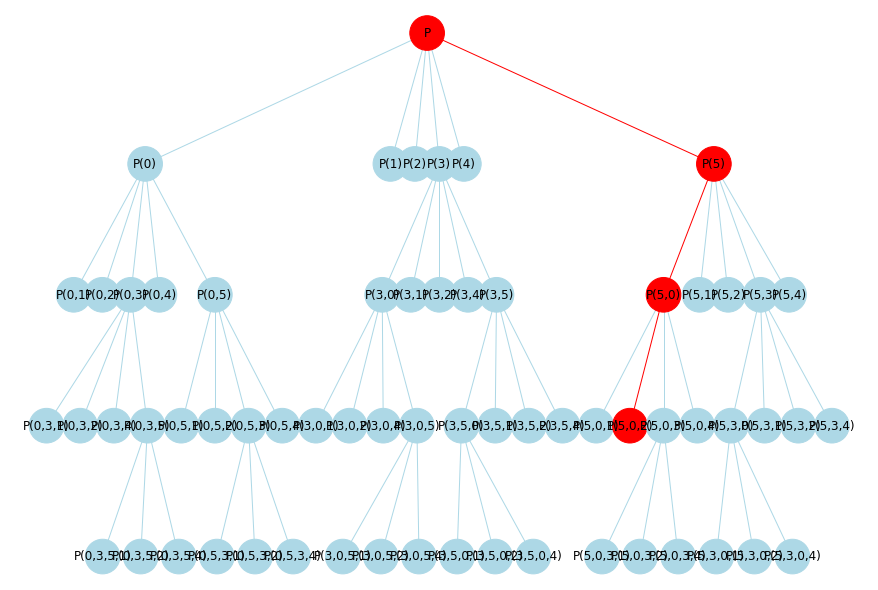

In [27]:
p,d,w = genInstancies(6)
print("p : ", p)
print("d : ", d)
print("w : ", w)
solution, order, nbIterations,branch,Tree = branch_and_bound2(p,d,w, True, getPrimal_2, getDual_2,exploration_1)
print("Final Results: {} Iterations".format(nbIterations))
print("Order : {} | Cost : {}".format(order,computeCost(p,d,w,order)))
print(branch)
displayTree(Tree,order,branch,True)

p :  [ 4 12  1  6 12  6  5  4]
d :  [39 14  9 45 26 24 18 20]
w :  [3 1 4 1 1 1 4 3]
Final Results: 186 Iterations
Order : [2, 1, 6, 7, 5, 0, 4, 3] | Cost : 33
['P(3,4,0,5,7,6,1,2)', 'P(3,4,0,5,7,6,1)', 'P(3,4,0,5,7,6)', 'P(3,4,0,5,7)', 'P(3,4,0,5)', 'P(3,4,0)', 'P(3,4)', 'P(3)', 'P']


/Users/Nathan/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/Nathan/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


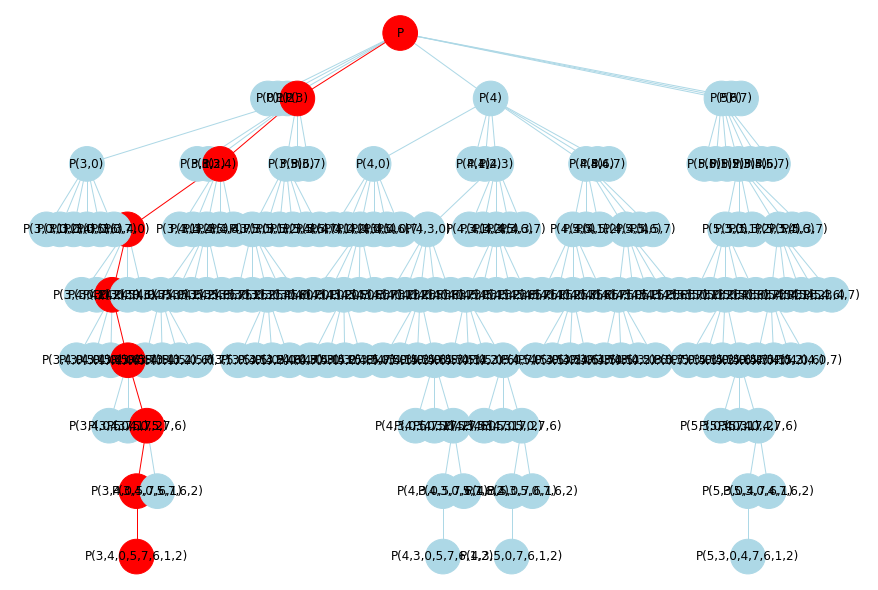

In [28]:
p,d,w = genInstancies(8)
print("p : ", p)
print("d : ", d)
print("w : ", w)
solution, order, nbIterations,branch,Tree = branch_and_bound2(p,d,w, True, getPrimal_2, getDual_2,exploration_1)
print("Final Results: {} Iterations".format(nbIterations))
print("Order : {} | Cost : {}".format(order,computeCost(p,d,w,order)))
print(branch)
displayTree(Tree,order,branch,True)